In [1]:
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import vispy
from PIL import Image
from sklearn.cluster import KMeans
from vispy.scene import Line, Markers

from graph_fusion_eds import create_edsbse_graph
from models import GATmodel


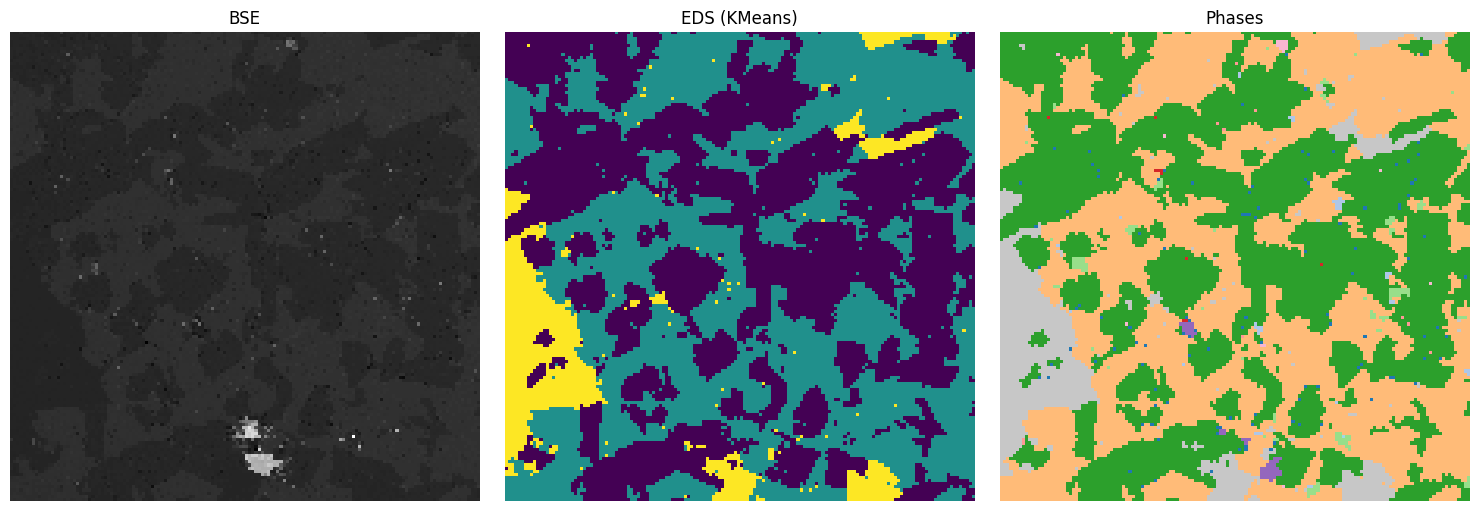

In [2]:
# load data
bse = np.array(Image.open("data/bse.png")) / 65535 # normalize (uint16)
eds = np.load("data/eds.npz")["eds"]
phases = np.array(Image.open("data/phases.tiff"))

# Reduce EDS data to 3 clusters for visualization
kmeans = KMeans(n_clusters=3, random_state=0).fit(eds)
eds_clustered = kmeans.labels_.reshape(bse.shape)

# plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(bse, cmap="gray")
axs[0].set_title("BSE")
axs[0].axis("off")

axs[1].imshow(eds_clustered, cmap="viridis")
axs[1].set_title("EDS (KMeans)")
axs[1].axis("off")

axs[2].imshow(phases, cmap="tab20")
axs[2].set_title("Phases")
axs[2].axis("off")

plt.tight_layout()
plt.show()


In [3]:
print(eds.dtype)

uint8


In [4]:

# Load embeddings model
# if you wonder why onnx, see README
session = ort.InferenceSession("models/eds_emb_model.onnx")

frac = 0.05
mask = np.random.random_sample(size=bse.shape) < frac

# prepare data
eds_input = eds.astype(np.float32)[mask.ravel(), 20:1556]
input_name = session.get_inputs()[0].name

# Run inference
embeddings = session.run(None, {input_name: eds_input})[0]
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (1117, 64)


In [5]:
# create graph
graph = create_edsbse_graph(bse, embeddings, phases, mask)

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
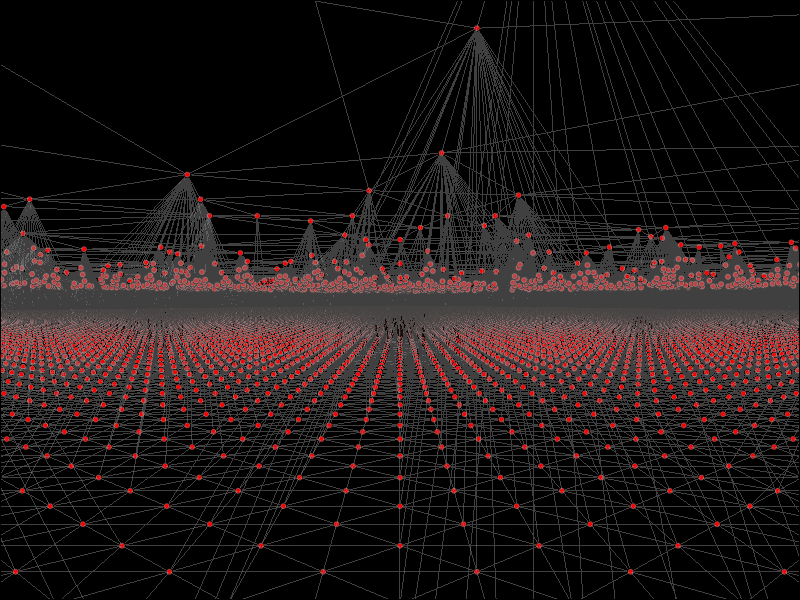

In [11]:
# show graph
edgepos = graph.pos[graph.edge_index.T].numpy()
canvas = vispy.scene.SceneCanvas(keys="interactive", show=True)
view = canvas.central_widget.add_view()

scatter = Markers()
scatter.set_data(graph.pos.numpy(), edge_width=0, face_color="red", size=5, symbol="o")

lines = Line(edgepos, connect="segments", color=(0.5, 0.5, 0.5, 0.5))

view.add(scatter)
view.add(lines)
view.camera = "turntable"  # set to "arcball" if you want to move around the center of rotation
view.camera.elevation = 0
view.camera.azimuth = 45
view.camera.distance = 100
canvas


In [7]:
# load model
model = GATmodel.load_from_checkpoint("models/model.ckpt", map_location="cpu")
model.eval();

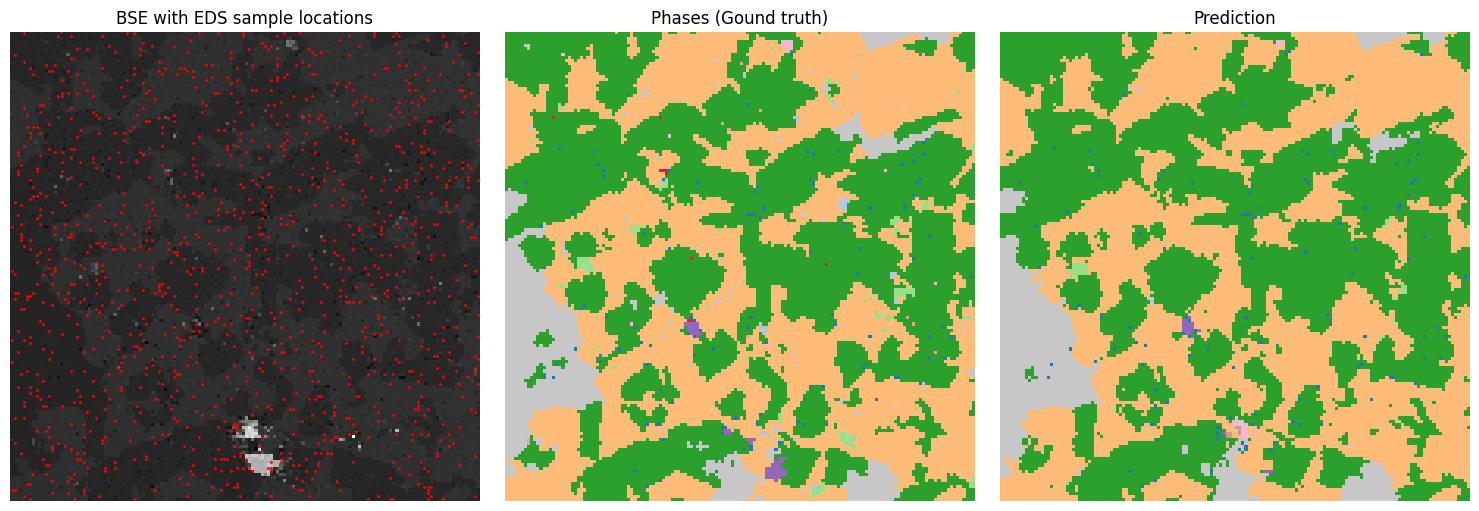

In [8]:
# create predictions
logits = model(graph.x, graph.edge_index, graph.edge_attr)
classes = logits.argmax(axis=1)
pred = classes[: 150**2].reshape(150, 150)

# show results
vmin = min(pred.min(), phases.min())
vmax = max(pred.max(), phases.max())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(bse, cmap="gray")
axs[0].set_title("BSE with EDS sample locations")
axs[0].axis("off")

# Overlay red points where mask is True
ys, xs = np.where(mask)
axs[0].scatter(xs, ys, c="red", s=1, marker="o")

axs[1].imshow(phases, cmap="tab20", vmin=vmin, vmax=vmax)
axs[1].set_title("Phases (Gound truth)")
axs[1].axis("off")

axs[2].imshow(pred, cmap="tab20", vmin=vmin, vmax=vmax)
axs[2].set_title("Prediction")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [9]:
print(f"Accuracy: {np.sum(pred.numpy() == phases) / pred.numel():.02f}")

Accuracy: 0.94
